In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import joblib

In [45]:
meps = pd.read_stata("h243.dta")
meps

,DUID,PID,DUPERSID,PANEL,DATAYEAR,FAMID31,FAMID42,FAMID53,FAMID22,FAMIDYR,...,RXOSR22,RXPTR22,RXOTH22,PERWT22F,FAMWT22F,FAMWT22C,SAQWT22F,DIABW22F,VARSTR,VARPSU
0,2460002,101,2460002101,24 PANEL 24,2022 YEAR,A,A,A,A,A,...,0,0,0,5728.309495,5232.211986,5232.211986,3994.687140,6034.636755,2082,1
1,2460006,101,2460006101,24 PANEL 24,2022 YEAR,A,A,A,A,A,...,0,0,0,15648.881461,16017.881691,16017.881691,0.000000,0.000000,2001,4
2,2460006,102,2460006102,24 PANEL 24,2022 YEAR,A,A,A,A,A,...,0,0,0,14123.720178,16017.881691,12580.731740,0.000000,0.000000,2001,4
3,2460010,101,2460010101,24 PANEL 24,2022 YEAR,A,A,A,A,A,...,0,5288,299,16982.054917,21905.758877,21905.758877,0.000000,0.000000,2038,3
4,2460018,101,2460018101,24 PANEL 24,2022 YEAR,A,A,A,A,A,...,0,10,0,10682.619947,11344.291012,11344.291012,17152.439412,0.000000,2041,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22426,2799694,101,2799694101,27 PANEL 27,2022 YEAR,A,A,A,A,A,...,0,231,0,21490.058502,24757.243908,24757.243908,30689.883735,0.000000,2015,2
22427,2799694,102,2799694102,27 PANEL 27,2022 YEAR,A,A,A,A,A,...,0,79,0,18828.710297,24757.243908,24757.243908,22648.236877,0.000000,2015,2
22428,2799695,101,2799695101,27 PANEL 27,2022 YEAR,A,A,A,A,A,...,0,0,0,15992.756873,18382.130170,18382.130170,20512.235130,0.000000,2045,1
22429,2799698,101,2799698101,27 PANEL 27,2022 YEAR,A,A,A,A,A,...,0,578,0,15771.415106,15430.797933,15430.797933,0.000000,0.000000,2103,3


In [46]:
df = meps  

wanted_cols = [
    # ID (keep DUPERSID)
    "DUPERSID",

    # Demographics
    "AGE22X", "SEX", "RACEV2X", "HISPANX", "MARRY22X",
    "EDUCYR", "FTSTU22X", "REGION22", 

    # Socioeconomic / Income
    "POVCAT22", "FAMINC22", "TTLP22X", "WAGEP22X", "BUSNP22X", "EMPST53",

    # Self-reported health & mental health
    "RTHLTH53", "MNHLTH53", "IADLHP31", "ADLHLP31",
    "ANYLMI22", "K6SUM42", "PHQ242",

    # Chronic conditions
    "HIBPDX", "CHDDX", "ANGIDX", "MIDX", "STRKDX", "EMPHDX",
    "CHOLDX", "CANCERDX", "ARTHDX", "ARTHTYPE", "ASTHDX",
    "ADHDADDX", "DIABDX_M18",

    # Insurance coverage
    "INSCOV22", "INSURC22", "PRVEV22", "TRIEV22",
    "MCREV22", "MCDEV22", "VAEV22", "UNINS22",

    # Weight / Utilization / BMI
    "ADBMI42",      # Adult BMI (ages 18+)
    "CHBMIX42",     # Child BMI (ages 6-17)
    "HAVEUS42",
    "FAMSZE22",

    # Target
    "TOTEXP22",
]

model_cols = [c for c in wanted_cols if c in df.columns]

meps = df[model_cols].copy()

In [47]:
# Demographics
meps.head().iloc[:, 0:9]

# Age top coded at 85 (85 indicates >= 85)

,DUPERSID,AGE22X,SEX,RACEV2X,HISPANX,MARRY22X,EDUCYR,FTSTU22X,REGION22
0,2460002101,77,2 FEMALE,2 BLACK - NO OTHER RACE REPORTED,2 NOT HISPANIC,2 WIDOWED,6,-1 INAPPLICABLE,2 MIDWEST
1,2460006101,64,2 FEMALE,1 WHITE - NO OTHER RACE REPORTED,2 NOT HISPANIC,3 DIVORCED,14 2 YEARS COLLEGE,-1 INAPPLICABLE,2 MIDWEST
2,2460006102,67,1 MALE,1 WHITE - NO OTHER RACE REPORTED,2 NOT HISPANIC,3 DIVORCED,17 5+ YEARS COLLEGE,-1 INAPPLICABLE,2 MIDWEST
3,2460010101,29,1 MALE,12 MULTIPLE RACES REPORTED,2 NOT HISPANIC,5 NEVER MARRIED,16 4 YEARS COLLEGE,-1 INAPPLICABLE,4 WEST
4,2460018101,51,2 FEMALE,1 WHITE - NO OTHER RACE REPORTED,2 NOT HISPANIC,3 DIVORCED,16 4 YEARS COLLEGE,-1 INAPPLICABLE,1 NORTHEAST


In [48]:
# Socioeconomic / Income
meps.head().iloc[:, 9:15]

,POVCAT22,FAMINC22,TTLP22X,WAGEP22X,BUSNP22X,EMPST53
0,3 LOW INCOME,22000,22000,0,0,4 NOT EMPLOYED DURING RD 5/3
1,1 POOR/NEGATIVE,5000,5000,0,-4000,4 NOT EMPLOYED DURING RD 5/3
2,4 MIDDLE INCOME,30740,30740,20240,0,3 JOB DURING RD 5/3 REF PERIOD
3,5 HIGH INCOME,106483,106483,106483,0,1 EMPLOYED AT RD 5/3 INT DATE
4,4 MIDDLE INCOME,45000,45000,45000,0,1 EMPLOYED AT RD 5/3 INT DATE


In [49]:
# health & mental health
meps.head().iloc[:, 15:22]

,RTHLTH53,MNHLTH53,IADLHP31,ADLHLP31,ANYLMI22,K6SUM42,PHQ242
0,3 GOOD,3 GOOD,1 YES,2 NO,1 YES,12,2
1,5 POOR,1 EXCELLENT,2 NO,2 NO,1 YES,-1 INAPPLICABLE,-1 INAPPLICABLE
2,1 EXCELLENT,1 EXCELLENT,2 NO,2 NO,2 NO,-1 INAPPLICABLE,-1 INAPPLICABLE
3,4 FAIR,3 GOOD,2 NO,2 NO,2 NO,-1 INAPPLICABLE,-1 INAPPLICABLE
4,2 VERY GOOD,4 FAIR,2 NO,2 NO,2 NO,5,1


In [50]:
# Chronic conditions
meps.head().iloc[:, 22:35]

,HIBPDX,CHDDX,ANGIDX,MIDX,STRKDX,EMPHDX,CHOLDX,CANCERDX,ARTHDX,ARTHTYPE,ASTHDX,ADHDADDX,DIABDX_M18
0,1 YES,2 NO,2 NO,2 NO,1 YES,2 NO,1 YES,1 YES,1 YES,3 NOT SPECIFIED,2 NO,-1 INAPPLICABLE,1 YES
1,1 YES,2 NO,2 NO,1 YES,2 NO,2 NO,2 NO,1 YES,1 YES,2 OSTEOARTHRITIS,2 NO,-1 INAPPLICABLE,2 NO
2,2 NO,2 NO,2 NO,2 NO,2 NO,2 NO,2 NO,2 NO,2 NO,-1 INAPPLICABLE,2 NO,-1 INAPPLICABLE,2 NO
3,2 NO,2 NO,2 NO,2 NO,2 NO,2 NO,2 NO,2 NO,2 NO,-1 INAPPLICABLE,2 NO,-1 INAPPLICABLE,2 NO
4,2 NO,2 NO,2 NO,2 NO,2 NO,2 NO,1 YES,2 NO,1 YES,2 OSTEOARTHRITIS,1 YES,-1 INAPPLICABLE,2 NO


In [51]:
# Insurance
meps.head().iloc[:, 35:43]

,INSCOV22,INSURC22,PRVEV22,TRIEV22,MCREV22,MCDEV22,VAEV22,UNINS22
0,2 PUBLIC ONLY,6 65+ EDITED MEDICARE AND OTH PUB ONLY,2 NO,2 NO,1 YES,1 YES,2 NO,2 NO
1,2 PUBLIC ONLY,2 <65 PUBLIC ONLY,2 NO,2 NO,1 YES,1 YES,2 NO,2 NO
2,2 PUBLIC ONLY,6 65+ EDITED MEDICARE AND OTH PUB ONLY,2 NO,2 NO,1 YES,1 YES,2 NO,2 NO
3,1 ANY PRIVATE,1 <65 ANY PRIVATE,1 YES,2 NO,2 NO,2 NO,2 NO,2 NO
4,1 ANY PRIVATE,1 <65 ANY PRIVATE,1 YES,2 NO,2 NO,2 NO,2 NO,2 NO


In [53]:
# BMI/ Utilization
meps.head().iloc[:, 43:47]

,ADBMI42,CHBMIX42,HAVEUS42,FAMSZE22
0,35.7,-1 INAPPLICABLE,1 YES,1 PERSON
1,-1 INAPPLICABLE,-1 INAPPLICABLE,1 YES,2 PERSONS
2,-1 INAPPLICABLE,-1 INAPPLICABLE,1 YES,2 PERSONS
3,-1 INAPPLICABLE,-1 INAPPLICABLE,2 NO,1 PERSON
4,27.4,-1 INAPPLICABLE,1 YES,1 PERSON


In [54]:
# Target (total annual health care expenditures for an individual in calendar year 2022)
meps[["TOTEXP22"]].head()

,TOTEXP22
0,15766
1,12697
2,3405
3,9265
4,3362


In [55]:
rename_map = {
    # IDs
    "DUPERSID": "person_id",

    # Demographics (NOTE: AGE22X is top-coded at 85 - values of 85 represent ages >= 85)
    "AGE22X": "age",
    "SEX": "sex",
    "RACEV2X": "race",
    "HISPANX": "hispanic",
    "MARRY22X": "marital_status",
    "EDUCYR": "education_years",
    "FTSTU22X": "is_student",
    "REGION22": "region_2022",

    # SES / income / employment
    "POVCAT22": "poverty_category",
    "FAMINC22": "family_income",          # (often categorical or edited; keep name explicit)
    "TTLP22X": "total_person_income",
    "WAGEP22X": "wage_income",
    "BUSNP22X": "business_income",
    "EMPST53": "employment_status",   # "53" ≈ end-of-year / late-round status (end of the year)

    # Self-reported health (end-of-year style)
    "RTHLTH53": "self_rated_health",                # (end of the year)
    "MNHLTH53": "self_rated_mental_health",

    # Functioning / disability help (round-based)
    "IADLHP31": "needs_help_iadl",       # IADL = instrumental activities of daily living
    "ADLHLP31": "needs_help_adl",        # ADl = acitivities of daily living

    # Mental health / distress scales
    "ANYLMI22": "any_mental_illness",
    "K6SUM42": "k6_distress_score",  # (round 4)
    "PHQ242": "phq2_depression_score",

    # Diagnoses (ever told by a doctor, typically)
    "HIBPDX": "dx_hypertension",
    "CHDDX": "dx_coronary_heart_disease",
    "ANGIDX": "dx_angina",
    "MIDX": "dx_myocardial_infarction",
    "STRKDX": "dx_stroke",
    "EMPHDX": "dx_emphysema",
    "CHOLDX": "dx_high_cholesterol",
    "CANCERDX": "dx_cancer",
    "ARTHDX": "dx_arthritis",
    "ARTHTYPE": "arthritis_type",
    "ASTHDX": "dx_asthma",
    "ADHDADDX": "dx_adhd_add",
    "DIABDX_M18": "dx_diabetes",

    # Insurance coverage
    "INSCOV22": "insured_full_year",       # coverage continuity style variable
    "INSURC22": "insurance_type",          # private/public/uninsured style category
    "PRVEV22": "has_private_insurance",
    "TRIEV22": "has_tricare",
    "MCREV22": "has_medicare",
    "MCDEV22": "has_medicaid",
    "VAEV22": "has_va_coverage",
    "UNINS22": "uninsured_status",

    # Weights / Utilization / BMI
    "ADBMI42": "bmi",              # Adult BMI (ages 18+), top-coded at 50, bottom-coded at 10
    "CHBMIX42": "child_bmi",       # Child BMI (ages 6-17), top-coded at 50, bottom-coded at 10
    "HAVEUS42": "has_usual_care",
    "FAMSZE22": "family_size",

    # Target
    "TOTEXP22": "total_healthcare_expenditure",
}

meps = meps.rename(columns=rename_map)

In [56]:
# Helper functions
def clean(series):
    """Replace MEPS reserved codes with NaN."""
    return series.replace({-1: np.nan, -2: np.nan, -7: np.nan, -8: np.nan, -9: np.nan, -10: np.nan, -13: np.nan, -15: np.nan})

def log1p(series):
    """Apply log1p transformation to a series."""
    return np.log1p(series.astype(float))

def signed_log1p(series):
    """Apply signed log1p transformation (handles negative values)."""
    return np.sign(series.astype(float)) * np.log1p(np.abs(series.astype(float)))

def remove_outliers(series):
    s = pd.to_numeric(series, errors="coerce")
    return s.clip(s.quantile(0.01), s.quantile(0.99))

def to_dollar(x, pos):
    """Format log-transformed values as dollar amounts."""
    return f"${np.expm1(x):,.0f}"

def to_income(x, pos):
    """Format signed log-transformed values as compact dollar amounts."""
    return f"${(np.sign(x) * np.expm1(np.abs(x)))/1000:,.0f}k"

In [57]:
# Cleaning Numerical Columns

# Clean missing values for all features
total_healthcare_expenditure_clean = clean(meps["total_healthcare_expenditure"])
family_income_clean = clean(meps["family_income"])
total_person_income_clean = clean(meps["total_person_income"])
wage_income_clean = clean(meps["wage_income"])
business_income_clean = clean(meps["business_income"])
age_clean = clean(meps["age"])  # NOTE: top-coded at 85 (values of 85 represent ages >= 85)
bmi_clean = clean(meps["bmi"])
bmi_clean = pd.to_numeric(bmi_clean, errors="coerce")  # Adult BMI (ages 18+)
child_bmi_clean = clean(meps["child_bmi"])
child_bmi_clean = pd.to_numeric(child_bmi_clean, errors="coerce")  # Child BMI (ages 6-17)

# Apply transformations
total_healthcare_expenditure_log1p = log1p(total_healthcare_expenditure_clean)
family_income_signed_log1p = signed_log1p(family_income_clean)
total_person_income_signed_log1p = signed_log1p(total_person_income_clean)
wage_income_signed_log1p = signed_log1p(wage_income_clean)
business_income_signed_log1p = signed_log1p(business_income_clean)

# Clip outliers
total_healthcare_expenditure_clipped = remove_outliers(total_healthcare_expenditure_log1p)
family_income_clipped = remove_outliers(family_income_signed_log1p)
total_person_income_clipped = remove_outliers(total_person_income_signed_log1p)
wage_income_clipped = remove_outliers(wage_income_signed_log1p)
business_income_clipped = remove_outliers(business_income_signed_log1p)
age_clipped = remove_outliers(age_clean)
bmi_clipped = remove_outliers(bmi_clean)
child_bmi_clipped = remove_outliers(child_bmi_clean)

## Histogram for Numeric Features (8 features)

**Notes:**
- `age`: Top-coded at 85 (values of 85 represent ages >= 85)
- `bmi`: Adult BMI (ages 18+), top-coded at 50, bottom-coded at 10
- `child_bmi`: Child BMI (ages 6-17), top-coded at 50, bottom-coded at 10

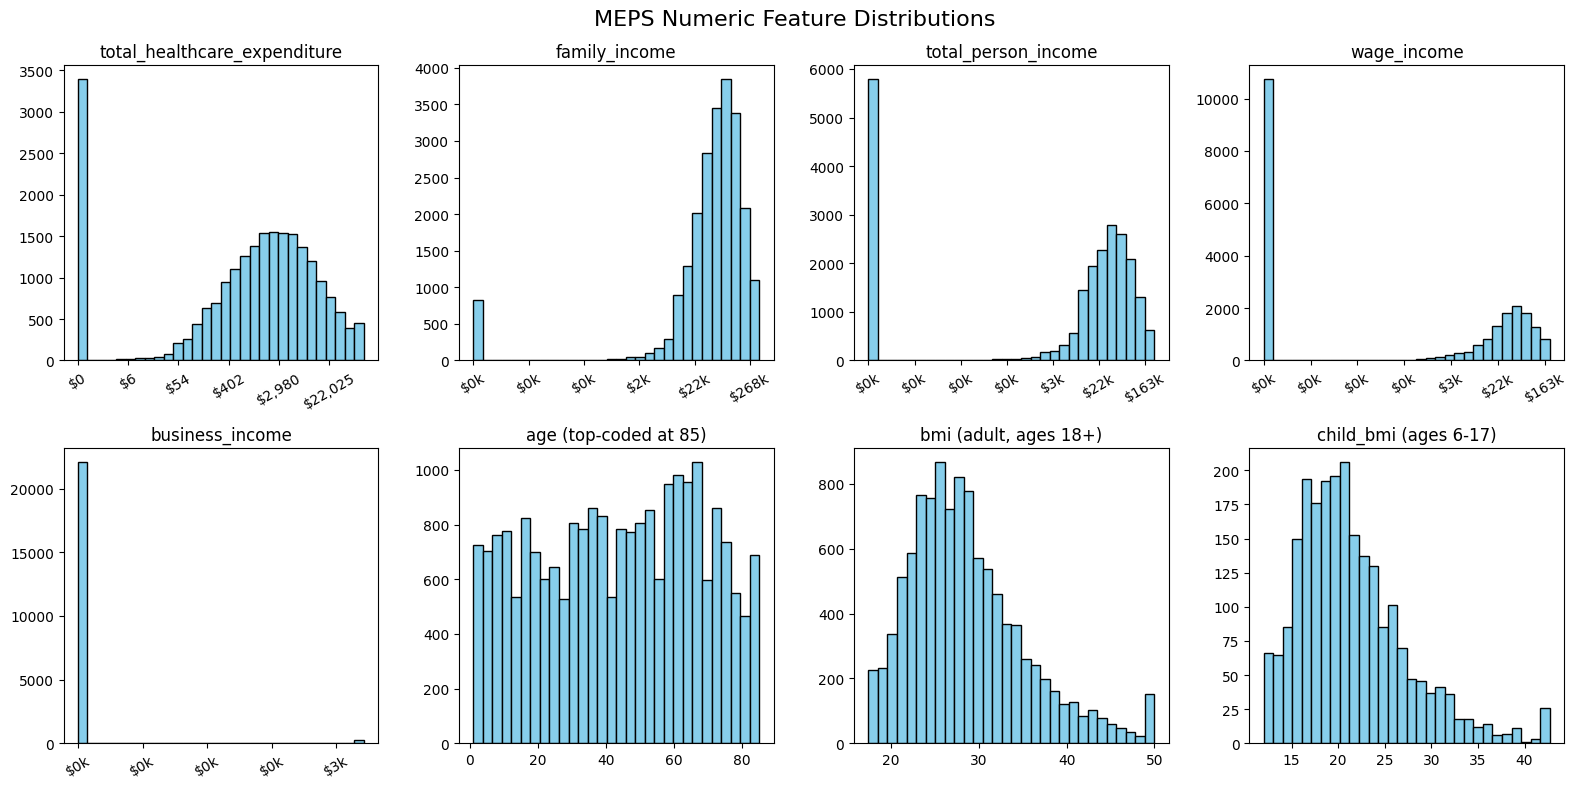

In [60]:
# Create figure with 8 subplots (2 rows x 4 cols)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# Target: Total Healthcare Expenditure (log1p transformed, dollar formatting)
axes[0].hist(total_healthcare_expenditure_clipped.dropna(), bins=30, color="skyblue", edgecolor="black")
axes[0].set_title("total_healthcare_expenditure")
axes[0].xaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[0].tick_params(axis="x", rotation=30)

# Income features (signed log1p transformed, compact dollar formatting)
axes[1].hist(family_income_clipped.dropna(), bins=30, color="skyblue", edgecolor="black")
axes[1].set_title("family_income")
axes[1].xaxis.set_major_formatter(FuncFormatter(to_income))
axes[1].tick_params(axis="x", rotation=30)

axes[2].hist(total_person_income_clipped.dropna(), bins=30, color="skyblue", edgecolor="black")
axes[2].set_title("total_person_income")
axes[2].xaxis.set_major_formatter(FuncFormatter(to_income))
axes[2].tick_params(axis="x", rotation=30)

axes[3].hist(wage_income_clipped.dropna(), bins=30, color="skyblue", edgecolor="black")
axes[3].set_title("wage_income")
axes[3].xaxis.set_major_formatter(FuncFormatter(to_income))
axes[3].tick_params(axis="x", rotation=30)

axes[4].hist(business_income_clipped.dropna(), bins=30, color="skyblue", edgecolor="black")
axes[4].set_title("business_income")
axes[4].xaxis.set_major_formatter(FuncFormatter(to_income))
axes[4].tick_params(axis="x", rotation=30)

# Age (top-coded at 85)
axes[5].hist(age_clipped.dropna(), bins=30, color="skyblue", edgecolor="black")
axes[5].set_title("age (top-coded at 85)")

# Adult BMI (ages 18+)
axes[6].hist(bmi_clipped.dropna(), bins=30, color="skyblue", edgecolor="black")
axes[6].set_title("bmi (adult, ages 18+)")

# Child BMI (ages 6-17)
axes[7].hist(child_bmi_clipped.dropna(), bins=30, color="skyblue", edgecolor="black")
axes[7].set_title("child_bmi (ages 6-17)")

plt.suptitle("MEPS Numeric Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()

## Heatmap for Numeric Features (8 features)

**Notes:**
- `bmi` and `child_bmi` are mutually exclusive (different age groups), so correlation between them will be NaN

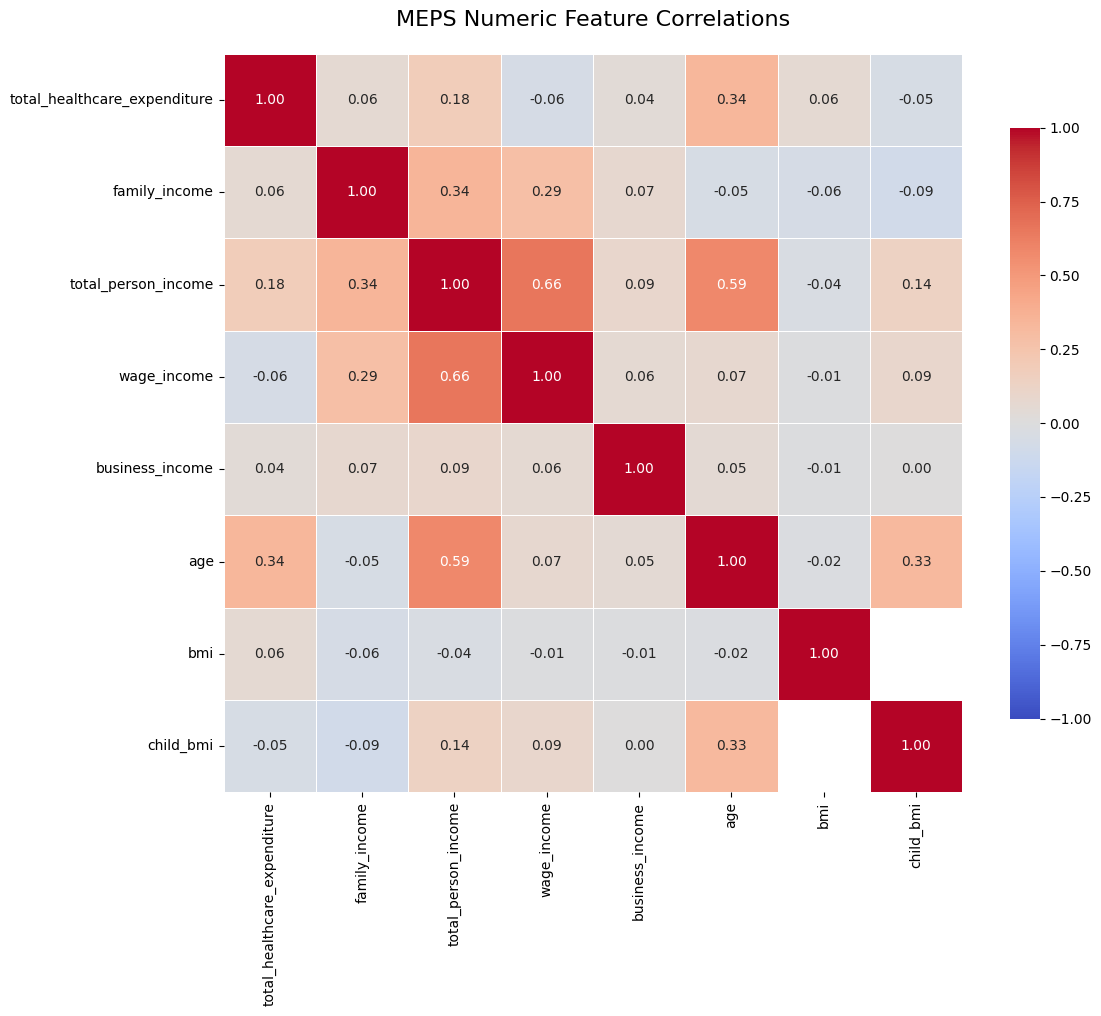

In [61]:
# correlation heatmap for numeric MEPS features
# Create correlation dataframe
corr_df = pd.DataFrame({
    "total_healthcare_expenditure": total_healthcare_expenditure_log1p,
    "family_income": family_income_signed_log1p,
    "total_person_income": total_person_income_signed_log1p,
    "wage_income": wage_income_signed_log1p,
    "business_income": business_income_signed_log1p,
    "age": age_clean,
    "bmi": bmi_clean,
    "child_bmi": child_bmi_clean
})

# Compute correlation matrix
correlation_matrix = corr_df.corr()

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("MEPS Numeric Feature Correlations", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

In [62]:
# Prepare data for boxplot visualizations
# Using log1p-transformed expenditure

target_clean = clean(meps["total_healthcare_expenditure"])
target_log1p = log1p(target_clean)

# Create analysis dataframe with target and all categorical features
analysis_df = pd.DataFrame({
    "expenditure_log": target_log1p,
    # Demographics
    "sex": meps["sex"],
    "race": meps["race"],
    "hispanic": meps["hispanic"],
    "marital_status": meps["marital_status"],
    "family_size": meps["family_size"],
    "education_years": clean(meps["education_years"]),
    "is_student": meps["is_student"],
    "region_2022": meps["region_2022"],
    # Socioeconomic
    "poverty_category": meps["poverty_category"],
    "employment_status": meps["employment_status"],
    # Health Status
    "self_rated_health": meps["self_rated_health"],
    "self_rated_mental_health": meps["self_rated_mental_health"],
    "needs_help_iadl": meps["needs_help_iadl"],
    "needs_help_adl": meps["needs_help_adl"],
    "any_mental_illness": meps["any_mental_illness"],
    "k6_distress_score": clean(meps["k6_distress_score"]),
    "phq2_depression_score": clean(meps["phq2_depression_score"]),
    # Chronic Conditions
    "dx_hypertension": meps["dx_hypertension"],
    "dx_coronary_heart_disease": meps["dx_coronary_heart_disease"],
    "dx_angina": meps["dx_angina"],
    "dx_myocardial_infarction": meps["dx_myocardial_infarction"],
    "dx_stroke": meps["dx_stroke"],
    "dx_emphysema": meps["dx_emphysema"],
    "dx_high_cholesterol": meps["dx_high_cholesterol"],
    "dx_cancer": meps["dx_cancer"],
    "dx_arthritis": meps["dx_arthritis"],
    "arthritis_type": meps["arthritis_type"],
    "dx_asthma": meps["dx_asthma"],
    "dx_adhd_add": meps["dx_adhd_add"],
    "dx_diabetes": meps["dx_diabetes"],
    # Insurance
    "insured_full_year": meps["insured_full_year"],
    "insurance_type": meps["insurance_type"],
    "has_private_insurance": meps["has_private_insurance"],
    "has_tricare": meps["has_tricare"],
    "has_medicare": meps["has_medicare"],
    "has_medicaid": meps["has_medicaid"],
    "has_va_coverage": meps["has_va_coverage"],
    "uninsured_status": meps["uninsured_status"],
    "has_usual_care": meps["has_usual_care"]
})

# Common variables for boxplots
yes_no_order = ["1 YES", "2 NO"]
yes_no_labels = ["Yes", "No"]

# Demographics Boxplots (8 features)

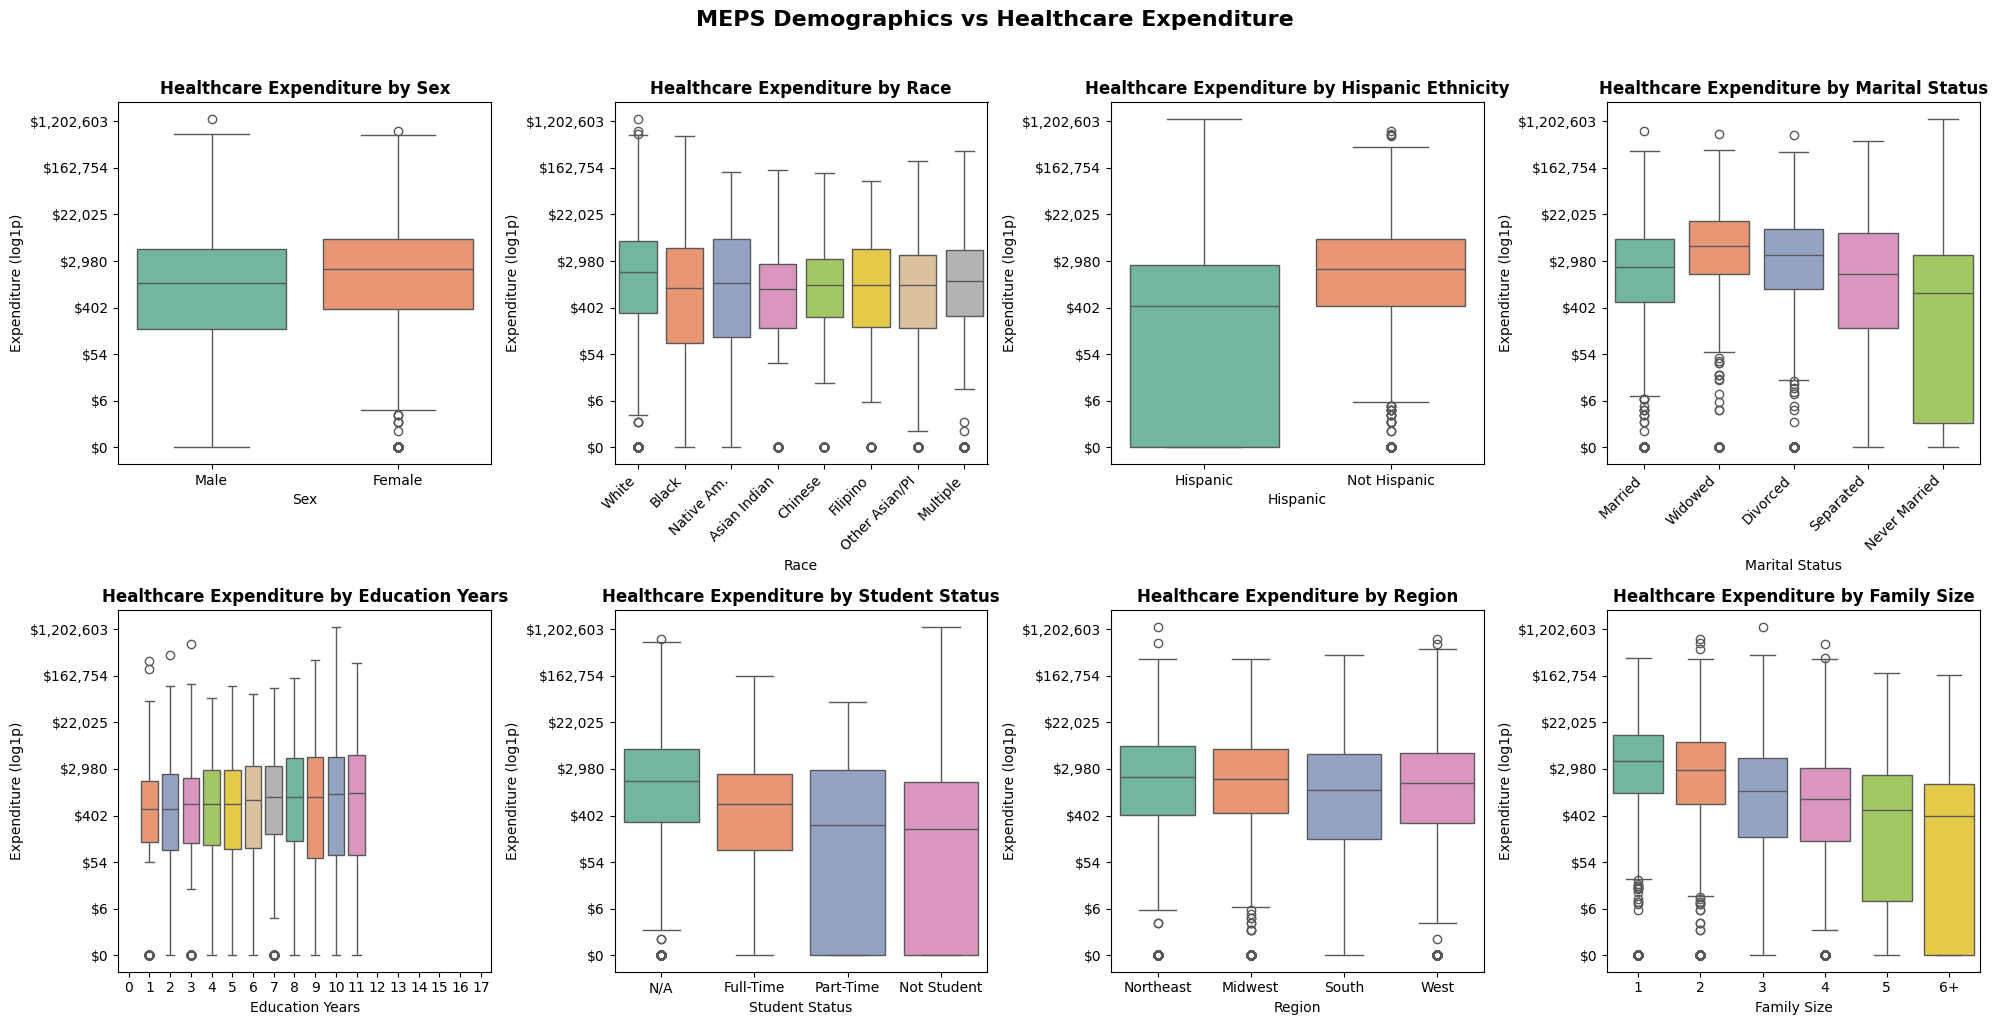

In [63]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Sex
sns.boxplot(data=analysis_df, x="sex", y="expenditure_log", ax=axes[0], palette="Set2", order=["1 MALE", "2 FEMALE"])
axes[0].set_title("Healthcare Expenditure by Sex", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Sex")
axes[0].set_ylabel("Expenditure (log1p)")
axes[0].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[0].set_xticklabels(["Male", "Female"])

# Race (updated to match actual data values)
race_order = [
    "1 WHITE - NO OTHER RACE REPORTED",
    "2 BLACK - NO OTHER RACE REPORTED",
    "3 AMER INDIAN/ALASKA NATIVE-NO OTHER RACE",
    "4 ASIAN INDIAN - NO OTHER RACE REPORTED",
    "5 CHINESE - NO OTHER RACE REPORTED",
    "6 FILIPINO - NO OTHER RACE REPORTED",
    "10 OTH ASIAN/NATV HAWAIIAN/PACFC ISL-NO OTH",
    "12 MULTIPLE RACES REPORTED"
]
sns.boxplot(data=analysis_df, x="race", y="expenditure_log", ax=axes[1], palette="Set2", order=race_order)
axes[1].set_title("Healthcare Expenditure by Race", fontsize=12, fontweight="bold")
axes[1].set_xlabel("Race")
axes[1].set_ylabel("Expenditure (log1p)")
axes[1].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[1].set_xticklabels(["White", "Black", "Native Am.", "Asian Indian", "Chinese", "Filipino", "Other Asian/PI", "Multiple"], rotation=45, ha="right")

# Hispanic
sns.boxplot(data=analysis_df, x="hispanic", y="expenditure_log", ax=axes[2], palette="Set2", order=["1 HISPANIC", "2 NOT HISPANIC"])
axes[2].set_title("Healthcare Expenditure by Hispanic Ethnicity", fontsize=12, fontweight="bold")
axes[2].set_xlabel("Hispanic")
axes[2].set_ylabel("Expenditure (log1p)")
axes[2].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[2].set_xticklabels(["Hispanic", "Not Hispanic"])

# Marital Status
marital_order = ["1 MARRIED", "2 WIDOWED", "3 DIVORCED", "4 SEPARATED", "5 NEVER MARRIED"]
sns.boxplot(data=analysis_df, x="marital_status", y="expenditure_log", ax=axes[3], palette="Set2", order=marital_order)
axes[3].set_title("Healthcare Expenditure by Marital Status", fontsize=12, fontweight="bold")
axes[3].set_xlabel("Marital Status")
axes[3].set_ylabel("Expenditure (log1p)")
axes[3].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[3].set_xticklabels(["Married", "Widowed", "Divorced", "Separated", "Never Married"], rotation=45, ha="right")

# Education Years (numeric 0-17)
education_order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
sns.boxplot(data=analysis_df, x="education_years", y="expenditure_log", ax=axes[4], palette="Set2", order=education_order)
axes[4].set_title("Healthcare Expenditure by Education Years", fontsize=12, fontweight="bold")
axes[4].set_xlabel("Education Years")
axes[4].set_ylabel("Expenditure (log1p)")
axes[4].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[4].tick_params(axis="x", rotation=0)

# Is Student (updated to match actual data values)
student_order = ["-1 INAPPLICABLE", "1 FULL-TIME STUDENT", "2 PART-TIME STUDENT", "3 NOT A STUDENT"]
sns.boxplot(data=analysis_df, x="is_student", y="expenditure_log", ax=axes[5], palette="Set2", order=student_order)
axes[5].set_title("Healthcare Expenditure by Student Status", fontsize=12, fontweight="bold")
axes[5].set_xlabel("Student Status")
axes[5].set_ylabel("Expenditure (log1p)")
axes[5].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[5].set_xticklabels(["N/A", "Full-Time", "Part-Time", "Not Student"])

# Region
region_order = ["1 NORTHEAST", "2 MIDWEST", "3 SOUTH", "4 WEST"]
sns.boxplot(data=analysis_df, x="region_2022", y="expenditure_log", ax=axes[6], palette="Set2", order=region_order)
axes[6].set_title("Healthcare Expenditure by Region", fontsize=12, fontweight="bold")
axes[6].set_xlabel("Region")
axes[6].set_ylabel("Expenditure (log1p)")
axes[6].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[6].set_xticklabels(["Northeast", "Midwest", "South", "West"])

# Family Size (updated to match actual data values)
family_size_order = ["1 PERSON", "2 PERSONS", "3 PERSONS", "4", "5", "6"]
sns.boxplot(data=analysis_df, x="family_size", y="expenditure_log", ax=axes[7], palette="Set2", order=family_size_order)
axes[7].set_title("Healthcare Expenditure by Family Size", fontsize=12, fontweight="bold")
axes[7].set_xlabel("Family Size")
axes[7].set_ylabel("Expenditure (log1p)")
axes[7].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[7].set_xticklabels(["1", "2", "3", "4", "5", "6+"])

plt.suptitle("MEPS Demographics vs Healthcare Expenditure", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

# Socioeconomic Boxplots (2 features)

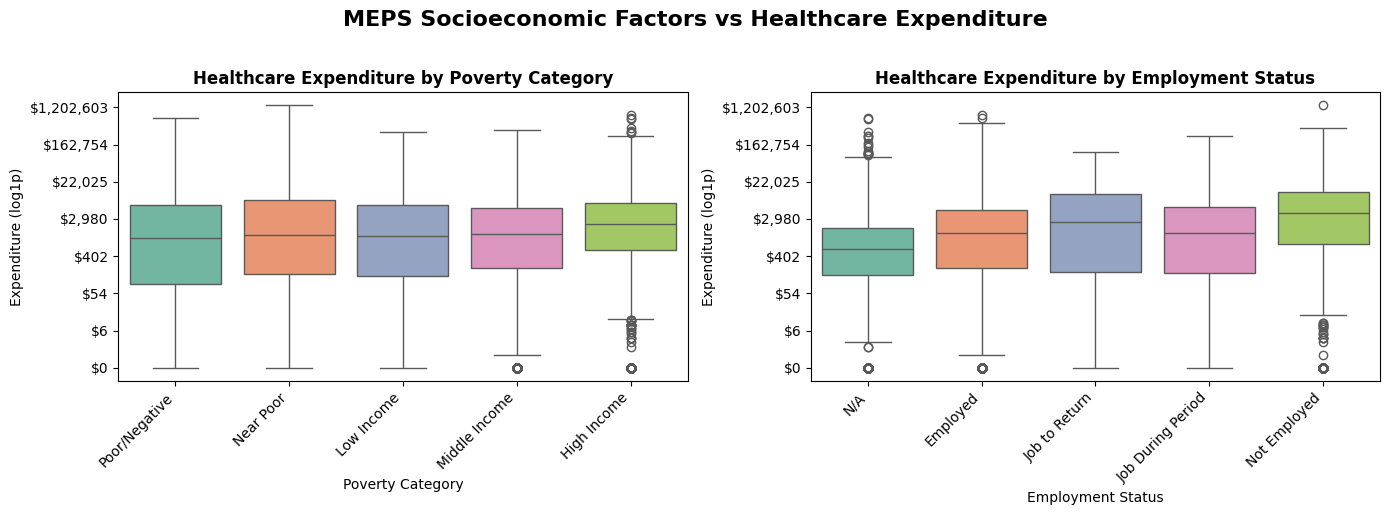

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Poverty Category
poverty_order = ["1 POOR/NEGATIVE", "2 NEAR POOR", "3 LOW INCOME", "4 MIDDLE INCOME", "5 HIGH INCOME"]
sns.boxplot(data=analysis_df, x="poverty_category", y="expenditure_log", ax=axes[0], palette="Set2", order=poverty_order)
axes[0].set_title("Healthcare Expenditure by Poverty Category", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Poverty Category")
axes[0].set_ylabel("Expenditure (log1p)")
axes[0].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[0].set_xticklabels(["Poor/Negative", "Near Poor", "Low Income", "Middle Income", "High Income"], rotation=45, ha="right")

# Employment Status (updated to match actual data values, including INAPPLICABLE)
employment_order = [
    "-1 INAPPLICABLE",
    "1 EMPLOYED AT RD 5/3 INT DATE",
    "2 JOB TO RETURN TO AT RD 5/3 INT DATE",
    "3 JOB DURING RD 5/3 REF PERIOD",
    "4 NOT EMPLOYED DURING RD 5/3"
]
sns.boxplot(data=analysis_df, x="employment_status", y="expenditure_log", ax=axes[1], palette="Set2", order=employment_order)
axes[1].set_title("Healthcare Expenditure by Employment Status", fontsize=12, fontweight="bold")
axes[1].set_xlabel("Employment Status")
axes[1].set_ylabel("Expenditure (log1p)")
axes[1].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[1].set_xticklabels(["N/A", "Employed", "Job to Return", "Job During Period", "Not Employed"], rotation=45, ha="right")

plt.suptitle("MEPS Socioeconomic Factors vs Healthcare Expenditure", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

# Health Status Boxplots (7 features)

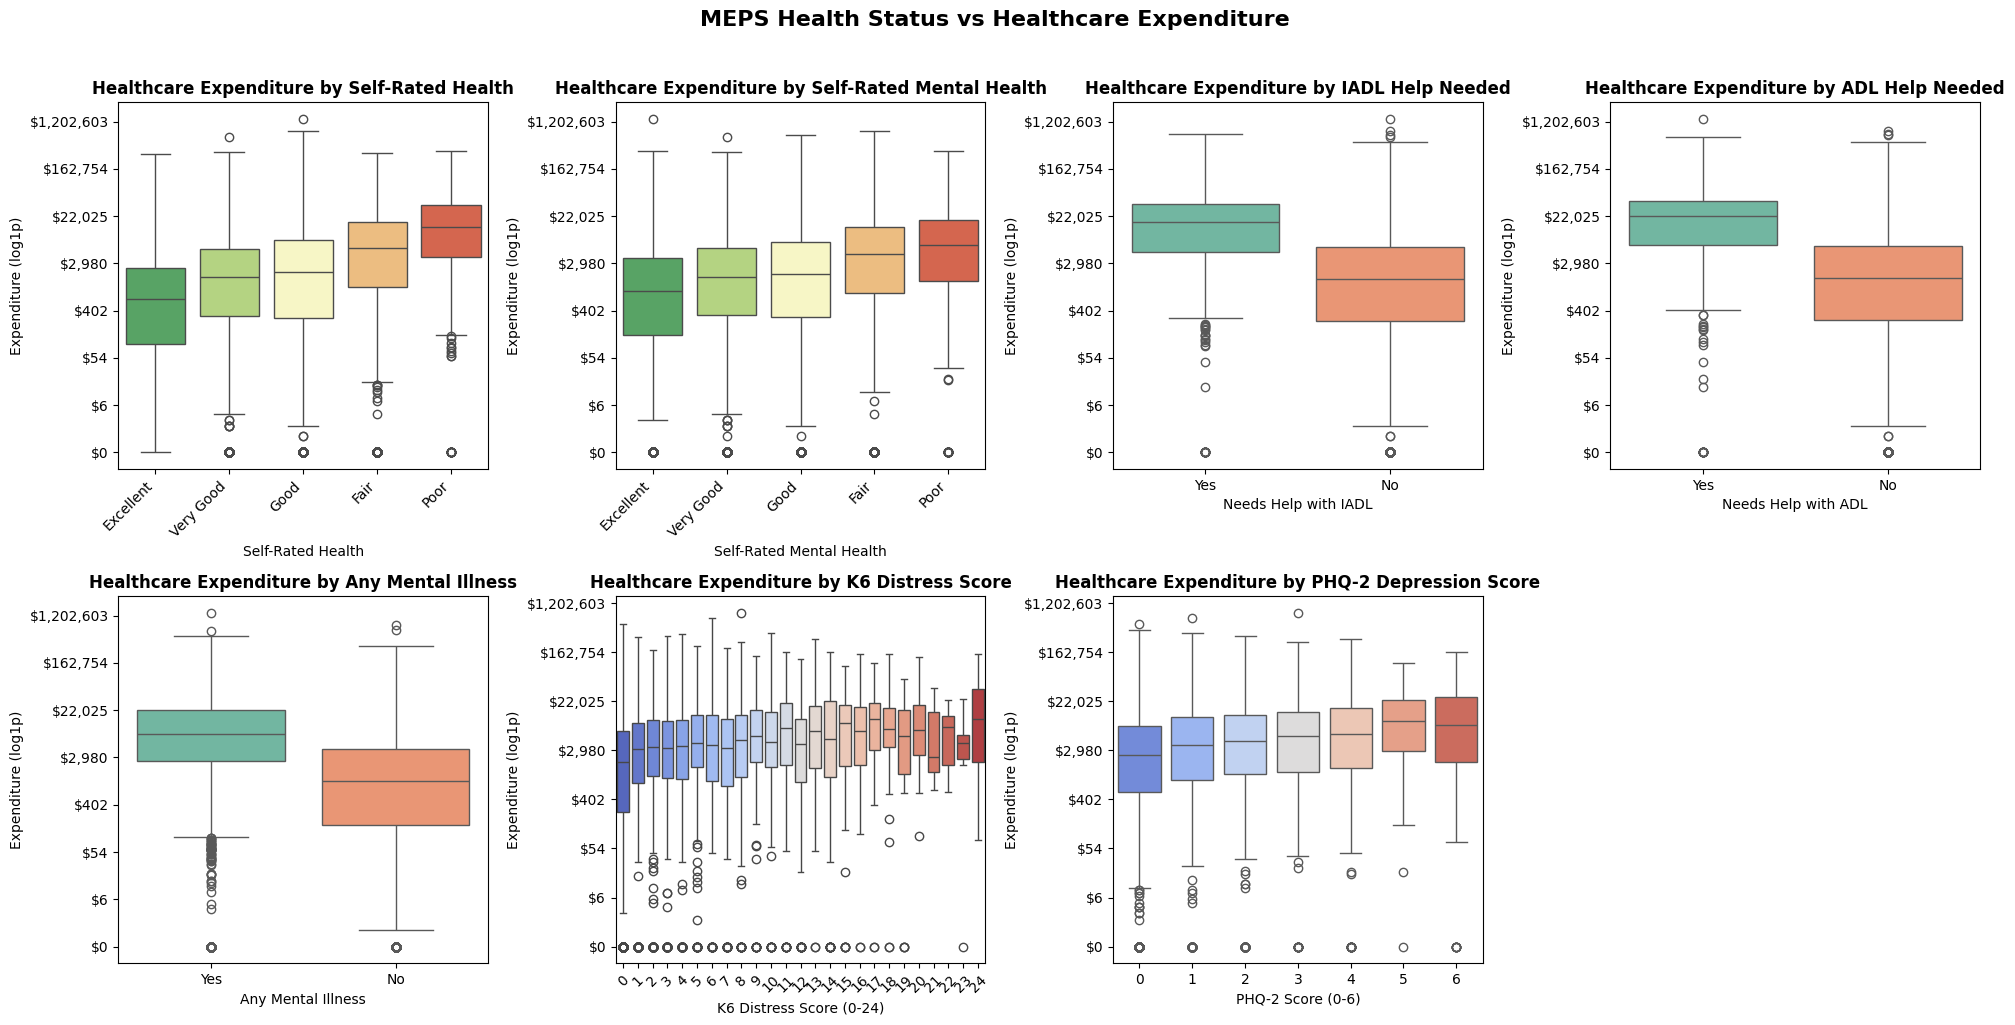

In [65]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Self-Rated Health
health_order = ["1 EXCELLENT", "2 VERY GOOD", "3 GOOD", "4 FAIR", "5 POOR"]
sns.boxplot(data=analysis_df, x="self_rated_health", y="expenditure_log", ax=axes[0], palette="RdYlGn_r", order=health_order)
axes[0].set_title("Healthcare Expenditure by Self-Rated Health", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Self-Rated Health")
axes[0].set_ylabel("Expenditure (log1p)")
axes[0].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[0].set_xticklabels(["Excellent", "Very Good", "Good", "Fair", "Poor"], rotation=45, ha="right")

# Self-Rated Mental Health
sns.boxplot(data=analysis_df, x="self_rated_mental_health", y="expenditure_log", ax=axes[1], palette="RdYlGn_r", order=health_order)
axes[1].set_title("Healthcare Expenditure by Self-Rated Mental Health", fontsize=12, fontweight="bold")
axes[1].set_xlabel("Self-Rated Mental Health")
axes[1].set_ylabel("Expenditure (log1p)")
axes[1].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[1].set_xticklabels(["Excellent", "Very Good", "Good", "Fair", "Poor"], rotation=45, ha="right")

# Needs Help IADL
iadl_order = ["1 YES", "2 NO"]
sns.boxplot(data=analysis_df, x="needs_help_iadl", y="expenditure_log", ax=axes[2], palette="Set2", order=iadl_order)
axes[2].set_title("Healthcare Expenditure by IADL Help Needed", fontsize=12, fontweight="bold")
axes[2].set_xlabel("Needs Help with IADL")
axes[2].set_ylabel("Expenditure (log1p)")
axes[2].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[2].set_xticklabels(["Yes", "No"])

# Needs Help ADL
adl_order = ["1 YES", "2 NO"]
sns.boxplot(data=analysis_df, x="needs_help_adl", y="expenditure_log", ax=axes[3], palette="Set2", order=adl_order)
axes[3].set_title("Healthcare Expenditure by ADL Help Needed", fontsize=12, fontweight="bold")
axes[3].set_xlabel("Needs Help with ADL")
axes[3].set_ylabel("Expenditure (log1p)")
axes[3].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[3].set_xticklabels(["Yes", "No"])

# Any Mental Illness
mental_order = ["1 YES", "2 NO"]
sns.boxplot(data=analysis_df, x="any_mental_illness", y="expenditure_log", ax=axes[4], palette="Set2", order=mental_order)
axes[4].set_title("Healthcare Expenditure by Any Mental Illness", fontsize=12, fontweight="bold")
axes[4].set_xlabel("Any Mental Illness")
axes[4].set_ylabel("Expenditure (log1p)")
axes[4].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[4].set_xticklabels(["Yes", "No"])

# K6 Distress Score (0-24 scale)
k6_order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
sns.boxplot(data=analysis_df, x="k6_distress_score", y="expenditure_log", ax=axes[5], palette="coolwarm", order=k6_order)
axes[5].set_title("Healthcare Expenditure by K6 Distress Score", fontsize=12, fontweight="bold")
axes[5].set_xlabel("K6 Distress Score (0-24)")
axes[5].set_ylabel("Expenditure (log1p)")
axes[5].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[5].tick_params(axis="x", rotation=45)

# PHQ-2 Depression Score (0-6 scale)
phq_order = [0, 1, 2, 3, 4, 5, 6]
sns.boxplot(data=analysis_df, x="phq2_depression_score", y="expenditure_log", ax=axes[6], palette="coolwarm", order=phq_order)
axes[6].set_title("Healthcare Expenditure by PHQ-2 Depression Score", fontsize=12, fontweight="bold")
axes[6].set_xlabel("PHQ-2 Score (0-6)")
axes[6].set_ylabel("Expenditure (log1p)")
axes[6].yaxis.set_major_formatter(FuncFormatter(to_dollar))

axes[7].axis("off")

plt.suptitle("MEPS Health Status vs Healthcare Expenditure", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

# Chronic Conditions Boxplots (13 features)

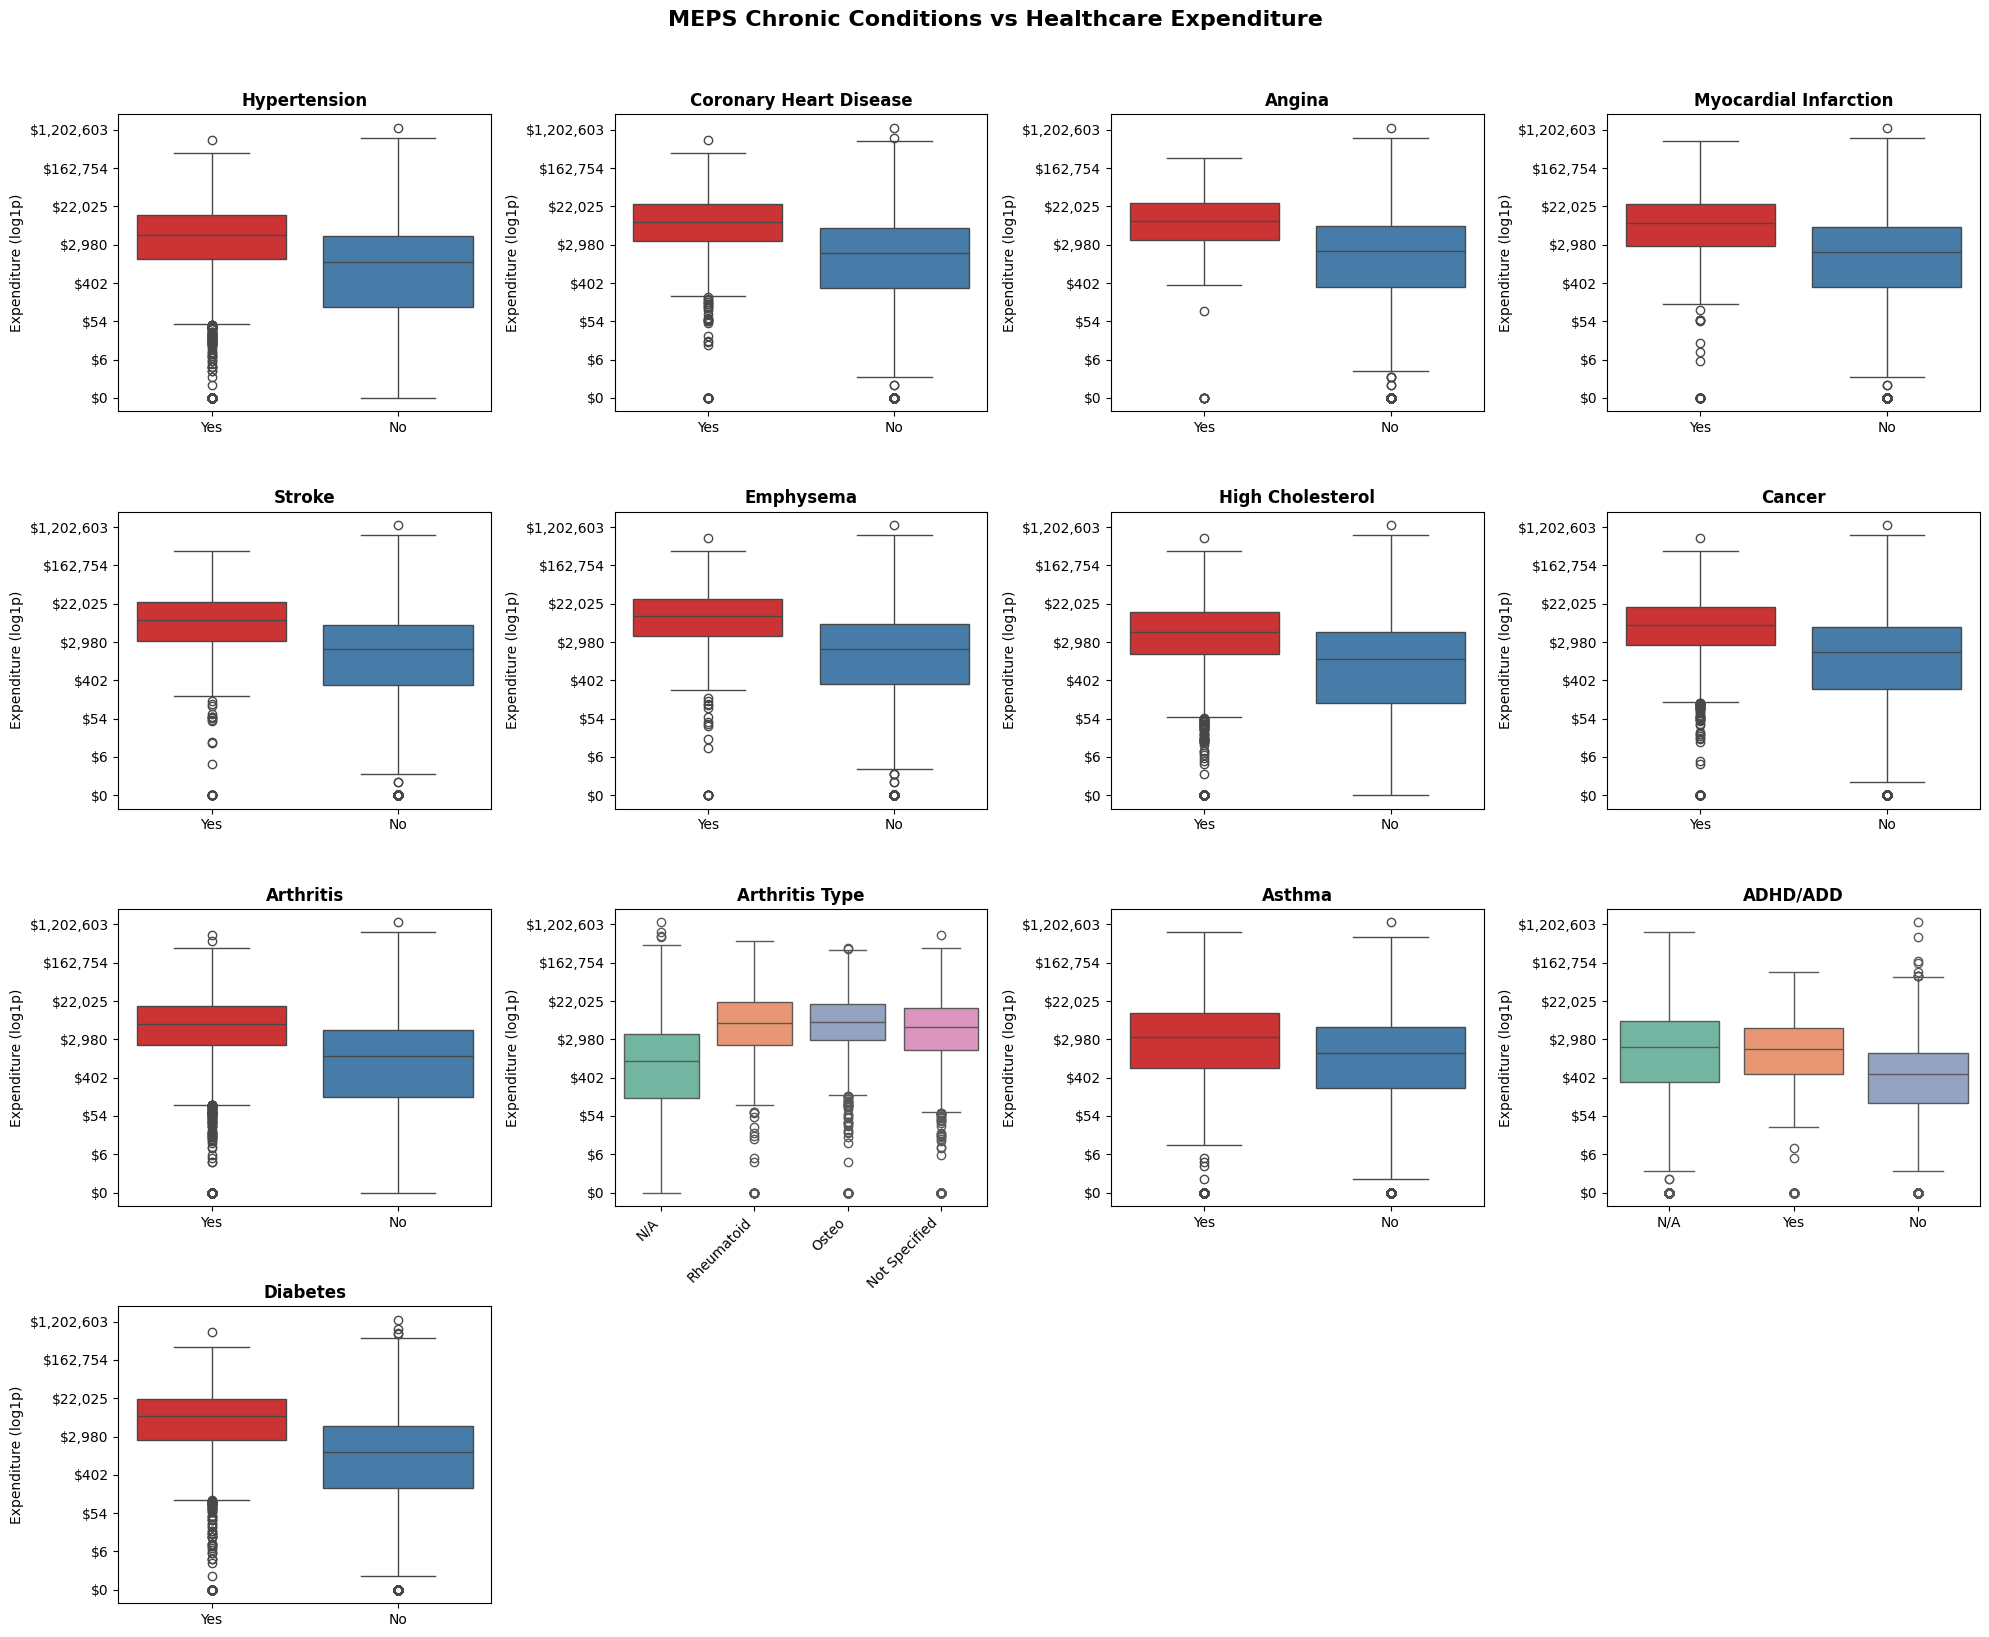

In [66]:
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
axes = axes.flatten()

# Hypertension
sns.boxplot(data=analysis_df, x="dx_hypertension", y="expenditure_log", ax=axes[0], palette="Set1", order=yes_no_order)
axes[0].set_title("Hypertension", fontsize=12, fontweight="bold")
axes[0].set_xlabel("")
axes[0].set_ylabel("Expenditure (log1p)")
axes[0].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[0].set_xticklabels(yes_no_labels)

# Coronary Heart Disease
sns.boxplot(data=analysis_df, x="dx_coronary_heart_disease", y="expenditure_log", ax=axes[1], palette="Set1", order=yes_no_order)
axes[1].set_title("Coronary Heart Disease", fontsize=12, fontweight="bold")
axes[1].set_xlabel("")
axes[1].set_ylabel("Expenditure (log1p)")
axes[1].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[1].set_xticklabels(yes_no_labels)

# Angina
sns.boxplot(data=analysis_df, x="dx_angina", y="expenditure_log", ax=axes[2], palette="Set1", order=yes_no_order)
axes[2].set_title("Angina", fontsize=12, fontweight="bold")
axes[2].set_xlabel("")
axes[2].set_ylabel("Expenditure (log1p)")
axes[2].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[2].set_xticklabels(yes_no_labels)

# Myocardial Infarction
sns.boxplot(data=analysis_df, x="dx_myocardial_infarction", y="expenditure_log", ax=axes[3], palette="Set1", order=yes_no_order)
axes[3].set_title("Myocardial Infarction", fontsize=12, fontweight="bold")
axes[3].set_xlabel("")
axes[3].set_ylabel("Expenditure (log1p)")
axes[3].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[3].set_xticklabels(yes_no_labels)

# Stroke
sns.boxplot(data=analysis_df, x="dx_stroke", y="expenditure_log", ax=axes[4], palette="Set1", order=yes_no_order)
axes[4].set_title("Stroke", fontsize=12, fontweight="bold")
axes[4].set_xlabel("")
axes[4].set_ylabel("Expenditure (log1p)")
axes[4].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[4].set_xticklabels(yes_no_labels)

# Emphysema
sns.boxplot(data=analysis_df, x="dx_emphysema", y="expenditure_log", ax=axes[5], palette="Set1", order=yes_no_order)
axes[5].set_title("Emphysema", fontsize=12, fontweight="bold")
axes[5].set_xlabel("")
axes[5].set_ylabel("Expenditure (log1p)")
axes[5].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[5].set_xticklabels(yes_no_labels)

# High Cholesterol
sns.boxplot(data=analysis_df, x="dx_high_cholesterol", y="expenditure_log", ax=axes[6], palette="Set1", order=yes_no_order)
axes[6].set_title("High Cholesterol", fontsize=12, fontweight="bold")
axes[6].set_xlabel("")
axes[6].set_ylabel("Expenditure (log1p)")
axes[6].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[6].set_xticklabels(yes_no_labels)

# Cancer
sns.boxplot(data=analysis_df, x="dx_cancer", y="expenditure_log", ax=axes[7], palette="Set1", order=yes_no_order)
axes[7].set_title("Cancer", fontsize=12, fontweight="bold")
axes[7].set_xlabel("")
axes[7].set_ylabel("Expenditure (log1p)")
axes[7].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[7].set_xticklabels(yes_no_labels)

# Arthritis
sns.boxplot(data=analysis_df, x="dx_arthritis", y="expenditure_log", ax=axes[8], palette="Set1", order=yes_no_order)
axes[8].set_title("Arthritis", fontsize=12, fontweight="bold")
axes[8].set_xlabel("")
axes[8].set_ylabel("Expenditure (log1p)")
axes[8].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[8].set_xticklabels(yes_no_labels)

# Arthritis Type
arthritis_type_order = ["-1 INAPPLICABLE", "1 RHEUMATOID ARTHRITIS", "2 OSTEOARTHRITIS", "3 NOT SPECIFIED"]
sns.boxplot(data=analysis_df, x="arthritis_type", y="expenditure_log", ax=axes[9], palette="Set2", order=arthritis_type_order)
axes[9].set_title("Arthritis Type", fontsize=12, fontweight="bold")
axes[9].set_xlabel("")
axes[9].set_ylabel("Expenditure (log1p)")
axes[9].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[9].set_xticklabels(["N/A", "Rheumatoid", "Osteo", "Not Specified"], rotation=45, ha="right")

# Asthma
sns.boxplot(data=analysis_df, x="dx_asthma", y="expenditure_log", ax=axes[10], palette="Set1", order=yes_no_order)
axes[10].set_title("Asthma", fontsize=12, fontweight="bold")
axes[10].set_xlabel("")
axes[10].set_ylabel("Expenditure (log1p)")
axes[10].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[10].set_xticklabels(yes_no_labels)

# ADHD/ADD
adhd_order = ["-1 INAPPLICABLE", "1 YES", "2 NO"]
sns.boxplot(data=analysis_df, x="dx_adhd_add", y="expenditure_log", ax=axes[11], palette="Set2", order=adhd_order)
axes[11].set_title("ADHD/ADD", fontsize=12, fontweight="bold")
axes[11].set_xlabel("")
axes[11].set_ylabel("Expenditure (log1p)")
axes[11].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[11].set_xticklabels(["N/A", "Yes", "No"])

# Diabetes
sns.boxplot(data=analysis_df, x="dx_diabetes", y="expenditure_log", ax=axes[12], palette="Set1", order=yes_no_order)
axes[12].set_title("Diabetes", fontsize=12, fontweight="bold")
axes[12].set_xlabel("")
axes[12].set_ylabel("Expenditure (log1p)")
axes[12].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[12].set_xticklabels(yes_no_labels)

# Hide unused subplots
axes[13].axis("off")
axes[14].axis("off")
axes[15].axis("off")

plt.suptitle("MEPS Chronic Conditions vs Healthcare Expenditure", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

# Insurance Coverage Boxplots (9 features)

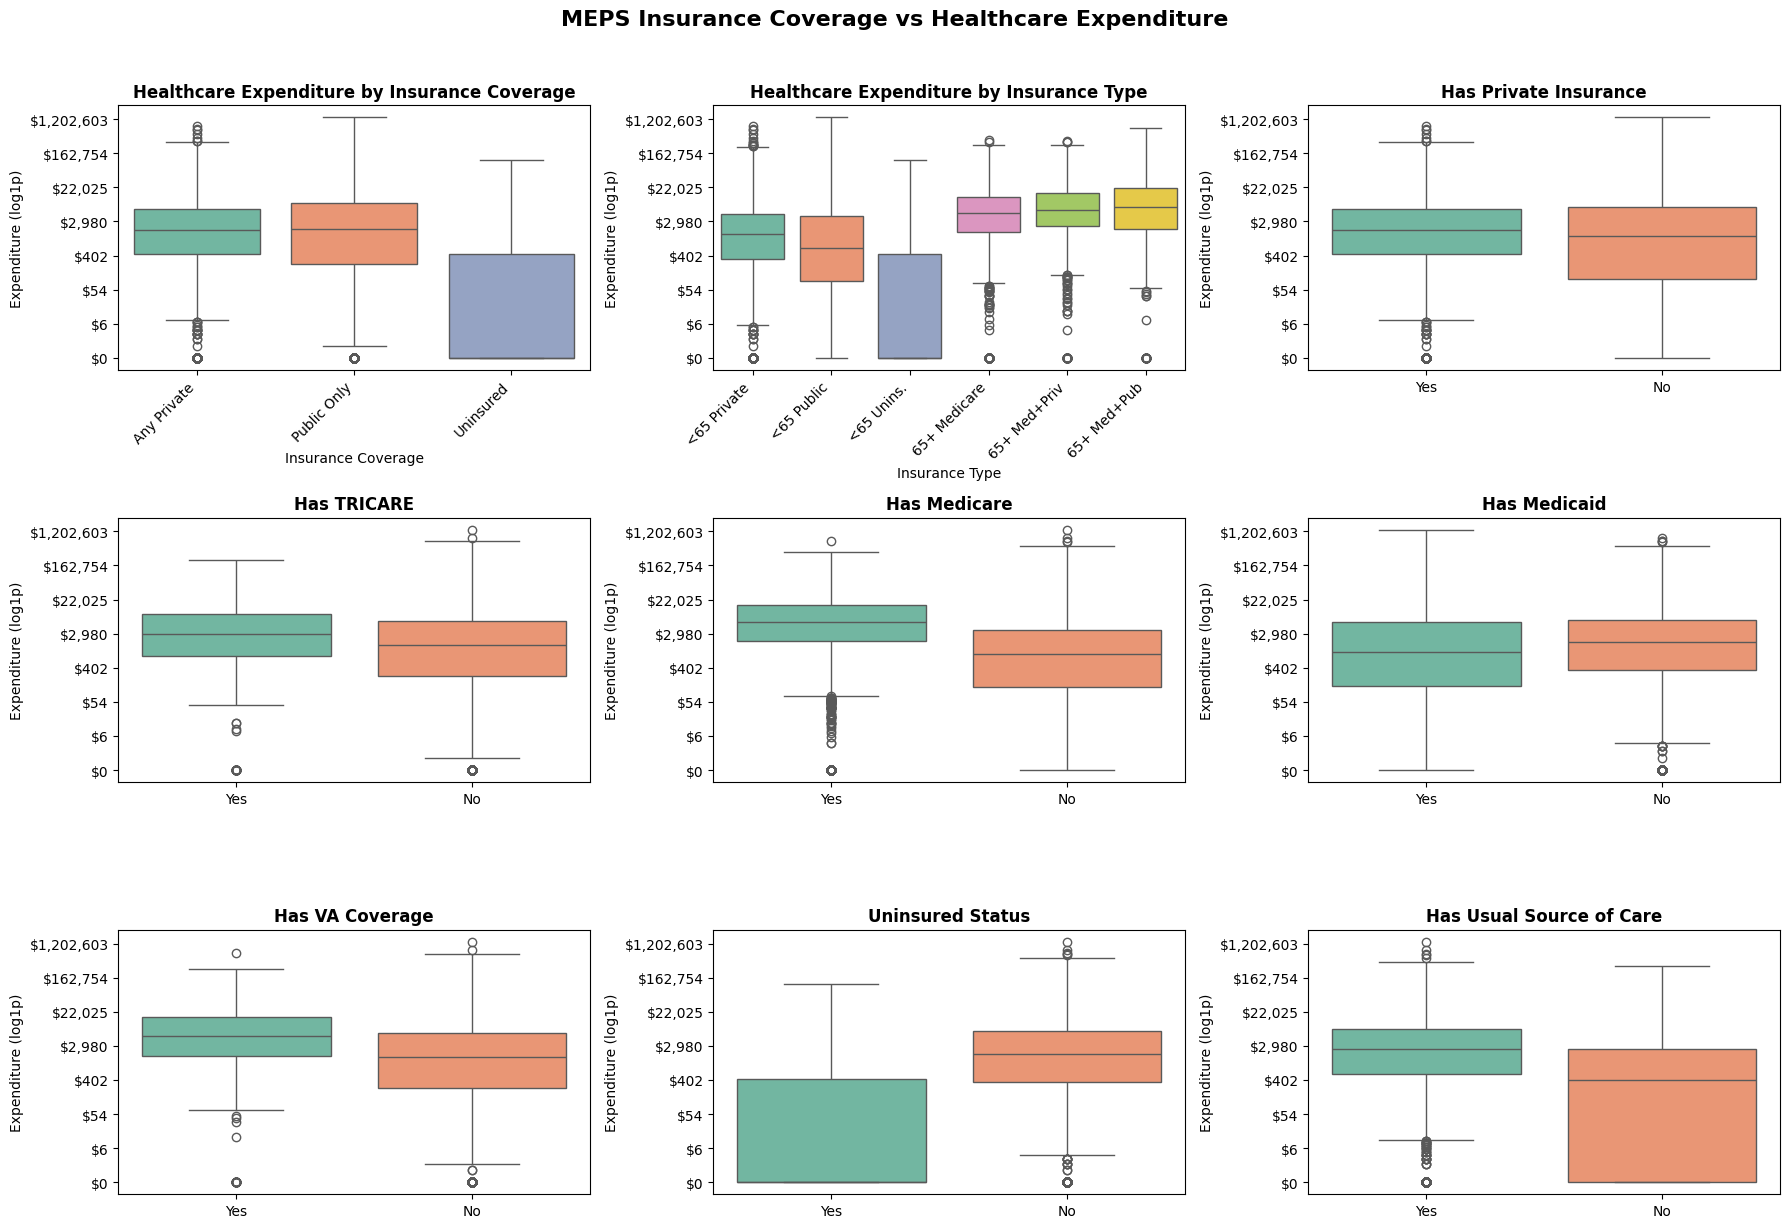

In [67]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

# Insured Full Year
insured_order = ["1 ANY PRIVATE", "2 PUBLIC ONLY", "3 UNINSURED"]
sns.boxplot(data=analysis_df, x="insured_full_year", y="expenditure_log", ax=axes[0], palette="Set2", order=insured_order)
axes[0].set_title("Healthcare Expenditure by Insurance Coverage", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Insurance Coverage")
axes[0].set_ylabel("Expenditure (log1p)")
axes[0].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[0].set_xticklabels(["Any Private", "Public Only", "Uninsured"], rotation=45, ha="right")

# Insurance Type (more detailed)
insurance_type_order = [
    "1 <65 ANY PRIVATE",
    "2 <65 PUBLIC ONLY",
    "3 <65 UNINSURED",
    "4 65+ EDITED MEDICARE ONLY",
    "5 65+ EDITED MEDICARE AND PRIVATE",
    "6 65+ EDITED MEDICARE AND OTH PUB ONLY"
]
sns.boxplot(data=analysis_df, x="insurance_type", y="expenditure_log", ax=axes[1], palette="Set2", order=insurance_type_order)
axes[1].set_title("Healthcare Expenditure by Insurance Type", fontsize=12, fontweight="bold")
axes[1].set_xlabel("Insurance Type")
axes[1].set_ylabel("Expenditure (log1p)")
axes[1].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[1].set_xticklabels(["<65 Private", "<65 Public", "<65 Unins.", "65+ Medicare", "65+ Med+Priv", "65+ Med+Pub"], rotation=45, ha="right")

# Has Private Insurance
sns.boxplot(data=analysis_df, x="has_private_insurance", y="expenditure_log", ax=axes[2], palette="Set2", order=yes_no_order)
axes[2].set_title("Has Private Insurance", fontsize=12, fontweight="bold")
axes[2].set_xlabel("")
axes[2].set_ylabel("Expenditure (log1p)")
axes[2].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[2].set_xticklabels(yes_no_labels)

# Has TRICARE
sns.boxplot(data=analysis_df, x="has_tricare", y="expenditure_log", ax=axes[3], palette="Set2", order=yes_no_order)
axes[3].set_title("Has TRICARE", fontsize=12, fontweight="bold")
axes[3].set_xlabel("")
axes[3].set_ylabel("Expenditure (log1p)")
axes[3].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[3].set_xticklabels(yes_no_labels)

# Has Medicare
sns.boxplot(data=analysis_df, x="has_medicare", y="expenditure_log", ax=axes[4], palette="Set2", order=yes_no_order)
axes[4].set_title("Has Medicare", fontsize=12, fontweight="bold")
axes[4].set_xlabel("")
axes[4].set_ylabel("Expenditure (log1p)")
axes[4].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[4].set_xticklabels(yes_no_labels)

# Has Medicaid
sns.boxplot(data=analysis_df, x="has_medicaid", y="expenditure_log", ax=axes[5], palette="Set2", order=yes_no_order)
axes[5].set_title("Has Medicaid", fontsize=12, fontweight="bold")
axes[5].set_xlabel("")
axes[5].set_ylabel("Expenditure (log1p)")
axes[5].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[5].set_xticklabels(yes_no_labels)

# Has VA Coverage
sns.boxplot(data=analysis_df, x="has_va_coverage", y="expenditure_log", ax=axes[6], palette="Set2", order=yes_no_order)
axes[6].set_title("Has VA Coverage", fontsize=12, fontweight="bold")
axes[6].set_xlabel("")
axes[6].set_ylabel("Expenditure (log1p)")
axes[6].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[6].set_xticklabels(yes_no_labels)

# Uninsured Status
sns.boxplot(data=analysis_df, x="uninsured_status", y="expenditure_log", ax=axes[7], palette="Set2", order=yes_no_order)
axes[7].set_title("Uninsured Status", fontsize=12, fontweight="bold")
axes[7].set_xlabel("")
axes[7].set_ylabel("Expenditure (log1p)")
axes[7].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[7].set_xticklabels(yes_no_labels)

# Has Usual Care
sns.boxplot(data=analysis_df, x="has_usual_care", y="expenditure_log", ax=axes[8], palette="Set2", order=yes_no_order)
axes[8].set_title("Has Usual Source of Care", fontsize=12, fontweight="bold")
axes[8].set_xlabel("")
axes[8].set_ylabel("Expenditure (log1p)")
axes[8].yaxis.set_major_formatter(FuncFormatter(to_dollar))
axes[8].set_xticklabels(yes_no_labels)

plt.suptitle("MEPS Insurance Coverage vs Healthcare Expenditure", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()